## Setup and Imports

In [13]:
import os
import shutil
import numpy as np
import torch

from datasets import load_dataset
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from transformers.image_utils import load_image
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)

from functools import partial

import evaluate

## Dataset

In [14]:
workdir = "data/fashion_mnist"

# Define transformations (convert images to tensors and normalize if needed)
transform = transforms.ToTensor()

# Download the FashionMNIST dataset
fashion_mnist = datasets.FashionMNIST(
    root=".",  # Temporary directory to store the raw dataset
    train=True,  # Download the training set
    download=True,  # Download the dataset if not already present
    transform=transform,
)

label_map = {0: "top", 1: "trouser"}

# Save each image as a separate file
for idx, (image, label) in enumerate(fashion_mnist):
    if label > 1:
        continue
    # Convert the tensor image to a PIL image
    pil_image = transforms.ToPILImage()(image)

    # Create a subdirectory for each label (optional)
    label_dir = os.path.join(workdir, str(label_map[label]))
    os.makedirs(label_dir, exist_ok=True)

    # Save the image to the corresponding label directory
    image_path = os.path.join(label_dir, f"image_{idx}.png")
    pil_image.save(image_path)


print(f"All images saved to: {workdir}")

shutil.rmtree("FashionMNIST")

All images saved to: data/fashion_mnist


In [ ]:
# Path to your dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset_path = "./data/fashion_mnist/"

# Load the dataset
dataset = ImageFolder(root="./data", transform=ToTensor())

In [25]:
dataset

Dataset ImageFolder
    Number of datapoints: 12000
    Root location: ./data
    StandardTransform
Transform: ToTensor()

In [ ]:
print(f"Number of training examples: {len(train_ds)}")
print(f"Number of validation examples: {len(val_ds)}")

Number of training examples: 75750
Number of validation examples: 25250


In [ ]:
labels = train_ds.features["label"].names
num_labels = len(labels)
print(f"Number of labels: {num_labels}")

# Build the dictionaries for easier query
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[i] = label

Number of labels: 101


### Visualize the dataset

In [ ]:
def display_image_grid(images, labels, rows=2, cols=5, figsize=(12, 6), target_size=(128, 128), after_aug=False):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if after_aug:
            image = images[i]
            image = image.permute(1, 2, 0)
            image = image.clip(min=0.0, max=1.0)
        else:
            image = images[i].resize((128, 128))
        ax.imshow(image)
        ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

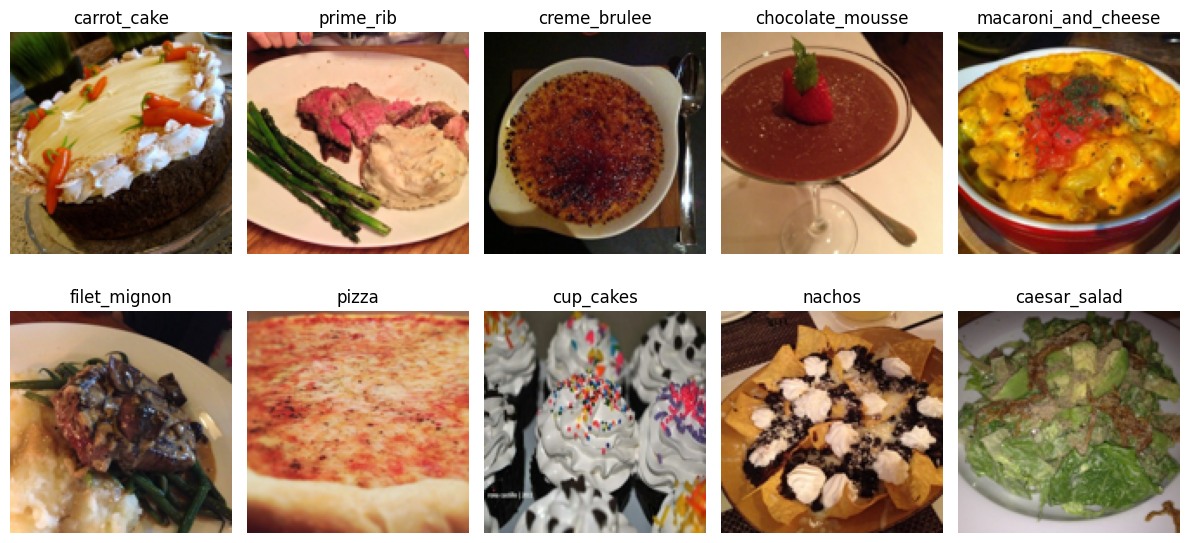

In [ ]:
samples = train_ds.shuffle().select(range(10))
sample_images = samples["image"]
sample_labels = [id2label[id] for id in samples["label"]]
display_image_grid(sample_images, sample_labels)

## Dataset Transforms for Traning

In [ ]:
checkpoint = "timm/vit_base_patch16_224.augreg2_in21k_ft_in1k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [ ]:
train_transforms = image_processor.train_transforms
val_transforms = image_processor.val_transforms


def apply_transforms(examples, train_aug=False):
    if train_aug:
        examples["pixel_values"] = [train_transforms(img.convert("RGB")) for img in examples["image"]]
    else:
        examples["pixel_values"] = [val_transforms(img.convert("RGB")) for img in examples["image"]]

    del examples["image"]
    return examples

In [ ]:
train_ds = train_ds.with_transform(partial(apply_transforms, train_aug=True))
val_ds = val_ds.with_transform(apply_transforms)

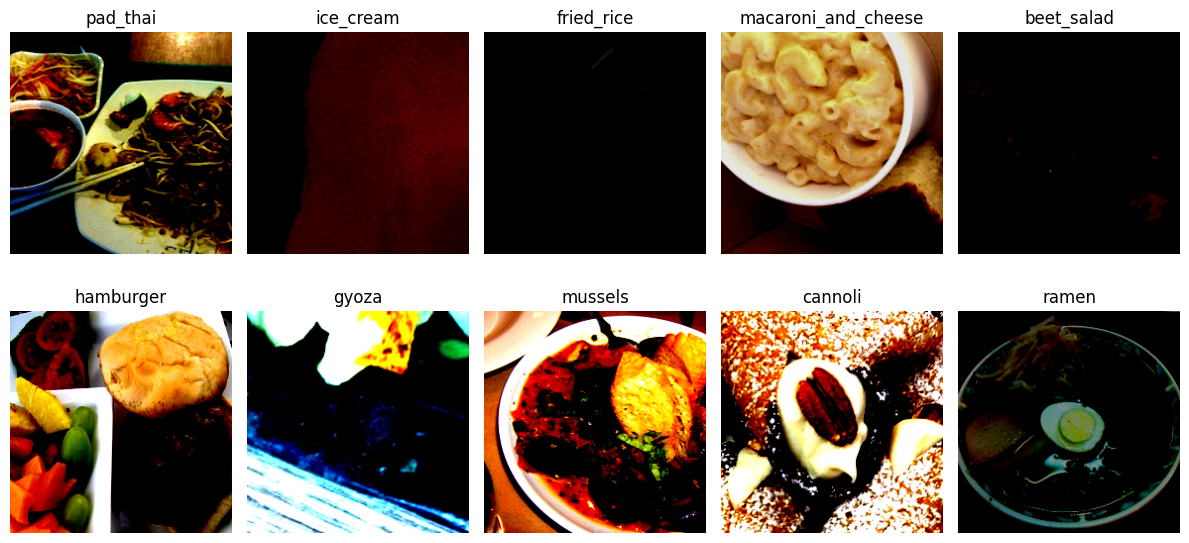

In [ ]:
samples = train_ds.shuffle().select(range(10))
sample_images = [s["pixel_values"] for s in samples]
sample_labels = [id2label[s["label"]] for s in samples]

# After augmentation
display_image_grid(sample_images, sample_labels, after_aug=True)

## Model

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of TimmWrapperForImageClassification were not initialized from the model checkpoint at timm/vit_base_patch16_224.augreg2_in21k_ft_in1k and are newly initialized because the shapes did not match:
- head.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- head.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [ ]:
learning_rate = 1e-5
batch_size = 128
num_epochs = 5
output_dir = f"ariG23498/{checkpoint.split('/')[1]}.ft_food101"

In [ ]:
print(output_dir)

ariG23498/vit_base_patch16_224.augreg2_in21k_ft_in1k.ft_food101


In [ ]:
accuracy = evaluate.load("accuracy")
data_collator = DefaultDataCollator()


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    warmup_ratio=0.2,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.818800,0.938696,0.767327
2,1.824700,0.505109,0.864158
3,1.432300,0.420241,0.885069


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
The `save_pretrained` method is disabled for TimmWrapperImageProcessor. The image processor configuration is saved directly in `config.json` when `save_pretrained` is called for saving the model.
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch,Training Loss,Validation Loss,Accuracy
1,2.818800,0.938696,0.767327
2,1.824700,0.505109,0.864158
3,1.432300,0.420241,0.885069
4,1.305900,0.381332,0.895089
5,1.334400,0.369427,0.897069


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
No files have been modified since last commit. Skipping to prevent empty commit.


TrainOutput(global_step=1480, training_loss=2.637090128056101, metrics={'train_runtime': 8968.634, 'train_samples_per_second': 42.231, 'train_steps_per_second': 0.165, 'total_flos': 2.9376133569216e+19, 'train_loss': 2.637090128056101, 'epoch': 5.0})

## Inference on Test Data

In [ ]:
image = load_image("https://cdn.britannica.com/52/128652-050-14AD19CA/Maki-zushi.jpg")
inputs = image_processor(image, return_tensors="pt")

In [ ]:
with torch.no_grad():
    logits = model(**inputs).logits
    labels = logits.argmax(-1).item()

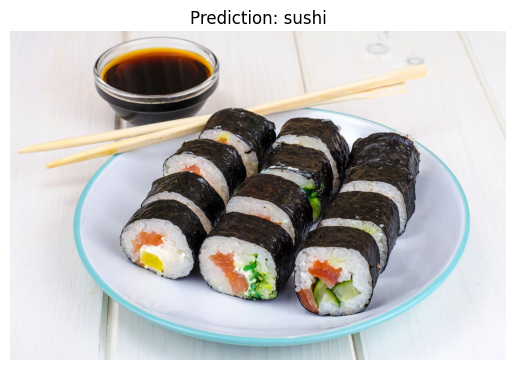

In [ ]:
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {id2label[labels]}")
plt.show()